<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/ML/NLP/NLP%20with%20Transformers/Emotion_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Transformers installation
#! pip install transformers datasets -q
#! pip install accelerate -U
! pip install scikit-learn
! pip install imbalanced-learn
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Text Classification

A common type of text classification is sentiment analysis, which (as we saw in <<chapter_introduction>>) aims to identify the polarity of a given text. For example, a company like Tesla might analyze Twitter posts like the one in <<tesla-tweet>> to determine whether people like its new car roofs or not.

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="images/chapter02_tweet.png" id="tesla-tweet"/>

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="images/chapter02_hf-libraries.png" id="hf-libraries"/>

## The Dataset

Building an **emotion detector** using a dataset from an article that explored how emotions are represented in English Twitter messages.footnote:[E. Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (Oct–Nov 2018): 3687–3697, http://dx.doi.org/10.18653/v1/D18-1404.]

Credit : Natural Language Processing with Transformers: Building Language Applications with Hugging Face, https://books.google.ch/books?id=7hhyzgEACAAJ

In [2]:
from datasets import list_datasets
# list of all available datasets
len(list_datasets())

<ipython-input-2-eaa7a1562849>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  len(list_datasets())
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


116765

In [3]:
from datasets import load_dataset

emotionData = load_dataset("emotion")
# The dataset is a dictionary already split into 3 parts: train, validation, test
# 16000 rows for training, and 2000 each for validation and testing
emotionData

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
# let's see first element of the dataset
print(emotionData["train"][0])
print(emotionData["validation"][0])
print(emotionData["test"][0])

{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon', 'label': 0}
{'text': 'im feeling rather rotten so im not very ambitious right now', 'label': 0}


In [5]:
# defining datasets
trainData = emotionData["train"]
validationData = emotionData["validation"]
testData = emotionData["test"]

In [6]:
# let's see what are the features
# Our input data is 3-dimensional
print(trainData.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
import pandas as pd

trainDf = trainData.to_pandas()
trainDf

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [8]:
# Add a new col for emotion in text format
def label_int2str(row):
 return trainData.features["label"].int2str(row)

trainDf["label_name"] = trainDf["label"].apply(label_int2str)
trainDf.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

As we can see the dataset is very unbalanced so what we can do is:
- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.

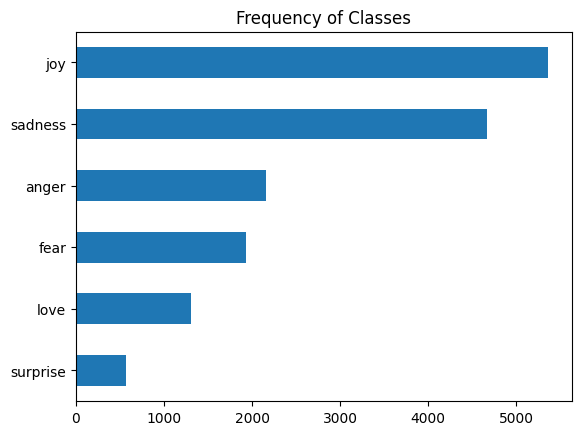

In [9]:
import matplotlib.pyplot as plt

trainDf["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [11]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from datasets import load_dataset

# Load the dataset
emotionData = load_dataset("emotion")

# Assuming 'train' is the training portion of your dataset
X_train = emotionData['train']['text']
y_train = emotionData['train']['label']

# Instantiate the random oversampler
oversampler = RandomOverSampler()

# Convert list to numpy array
X_train_array = np.array(X_train)

# Resample the dataset
X_resampled, y_resampled = oversampler.fit_resample(X_train_array.reshape(-1, 1), y_train)

# Convert back to original format
X_resampled = X_resampled.flatten()

# Now you can use X_resampled and y_resampled for training


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


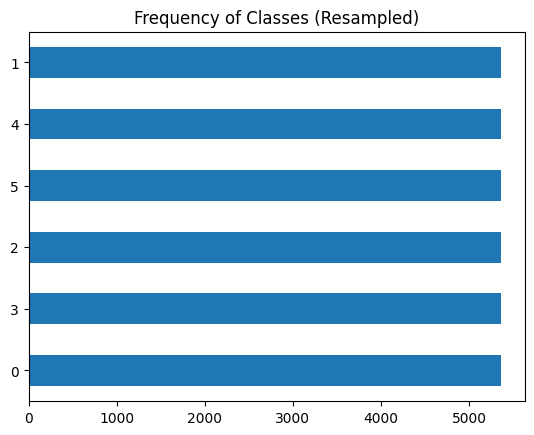

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert resampled training data to a DataFrame
resampled_df = pd.DataFrame({'text': X_resampled, 'label': y_resampled})

# Plot the frequency of classes
resampled_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes (Resampled)")
plt.show()

### How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

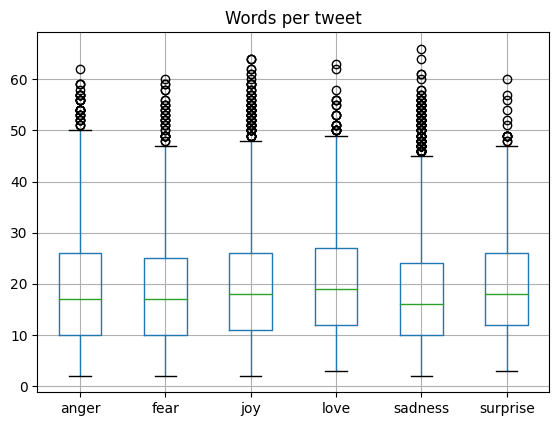

In [13]:
trainDf["Words per tweet"] = trainDf["text"].str.split().apply(len)
trainDf.boxplot("Words per tweet", by="label_name")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

Let's now figure out how we can convert these raw texts into a format suitable for 🤗Transformers! While we're at it, let's also reset the output format of our dataset since we don't need the `DataFrame` format anymore:

## From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been _tokenized_ and _encoded_ as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let's consider two extreme cases: _character_ and _word_ tokenization.

### Character Tokenization

The simplest tokenization scheme is to feed each character individually to the model. In Python, `str` objects are really arrays under the hood, which allows us to quickly implement character-level tokenization with just one line of code:

In [14]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a good start, but we're not done yet. Our model expects each character to be  converted to an integer, a process sometimes called _numericalization_. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [15]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


This gives us a mapping from each character in our vocabulary to a unique integer. We can now use `token2idx` to transform the tokenized text to a list of integers:

In [16]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Each token has now been mapped to a unique numerical identifier (hence the name `input_ids`). The last step is to convert `input_ids` to a 2D tensor of one-hot vectors. One-hot vectors are frequently used in machine learning to encode categorical data, which can be either ordinal or nominal. For example, suppose we wanted to encode the names of characters in the _Transformers_ TV series. One way to do this would be to map each name to a unique ID, as follows:

In [17]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a fictitious ordering between the names, and neural networks are _really_ good at learning these kinds of relationships. So instead, we can create a new column for each category and assign a 1 where the category is true, and a 0 otherwise. In Pandas, this can be implemented with the `get_dummies()` function as follows:

In [18]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


The rows of this `DataFrame` are the one-hot vectors, which have a single "hot" entry with a 1 and 0s everywhere else. Now, looking at our `input_ids`, we have a similar problem: the elements create an ordinal scale. This means that adding or subtracting two IDs is a meaningless operation, since the result is a new ID that represents another random token.

On the other hand, the result of adding two one-hot encodings can easily be interpreted: the two entries that are "hot" indicate that the corresponding tokens co-occur. We can create the one-hot encodings in PyTorch by converting `input_ids` to a tensor and applying the `one_hot()` function as follows:

In [19]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

For each of the 38 input tokens we now have a one-hot vector with 20 dimensions, since our vocabulary consists of 20 unique characters.

> Warning: It's important to always set `num_classes` in the `one_hot()` function because otherwise the one-hot vectors may end up being shorter than the length of the vocabulary (and need to be padded with zeros manually). In TensorFlow, the equivalent function is `tf.one_hot()`, where the `depth` argument plays the role of `num_classes`.

In [20]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
# This is a 1-hot vector
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example we can see that **character-level tokenization ignores any structure in the text and treats the whole string as a stream of characters**. Although this helps deal with misspellings and rare words, the main drawback is that **linguistic structures such as words need to be _learned_ from the data**. This requires significant compute, memory, and data. For this reason, character tokenization is rarely used in practice. Instead, some structure of the text is preserved during the tokenization step. _Word tokenization_ is a straightforward approach to achieve this, so let's take a look at how it works.

### Word Tokenization

Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.

In [21]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


We see that punctuation is not considered for now. This can be a problem with the size of the vocabulary can easily grow into the millions!

A common approach is to limit the vocabulary and discard rare words by considering, say, the 100,000 most common words in the corpus. Words that are not part of the vocabulary are classified as "unknown" and mapped to a shared `UNK` token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with `UNK`.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is _learned_ from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," _2012 IEEE International Conference on Acoustics, Speech and Signal Processing_ (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. 🤗Transformers provides a convenient `AutoTokenizer` class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [22]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The `AutoTokenizer` class belongs to a larger set of ["auto" classes](https://huggingface.co/docs/transformers/model_doc/auto) whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

In [23]:
# Passing to the tokenizer our text
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the `input_ids` field. We'll discuss the role of the `attention_mask` field in the next section. Now that we have the `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method:

In [24]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


We can observe three things here. First, some special `[CLS]` and `[SEP]` tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that "tokenizing" and "NLP" have been split into two tokens, which makes sense since they are not common words. The `##` prefix in `##izing` and `##p` means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The `AutoTokenizer` class has a `convert_tokens_to_string()` method for doing just that, so let's apply it to our tokens:

In [25]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


The `AutoTokenizer` class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:

In [26]:
tokenizer.vocab_size

30522

In [27]:
# Names of the fields expected in the foward pass
tokenizer.model_input_names

['input_ids', 'attention_mask']

> warning: When using pretrained models, it is _really_ important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat," you'd have a hard time understanding what was going on too!

### Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [28]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [29]:
emotionData['train'][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0]}

In [30]:
tokenize(emotionData["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Here we can see the result of padding: the first element of `input_ids` is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:

In [31]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input.

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="images/chapter02_attention-mask.png" id="attention-mask"/>

In [32]:
emotions_encoded = emotionData.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [33]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset.

> Note: In later chapters, we'll see how _data collators_ can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

## Training a Text Classifier

DistilBERT models are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in encoder-classifier.

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="images/chapter02_encoder-classifier.png" id="encoder-classifier"/>

First, the text is tokenized and represented as one-hot vectors called _token encodings_. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens.
Next, these token encodings are converted to _token embeddings_, which are vectors living in a lower-dimensional space.
The token embeddings are then passed through the encoder block layers to yield a _hidden state_ for each input token. Each hidden state is then fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

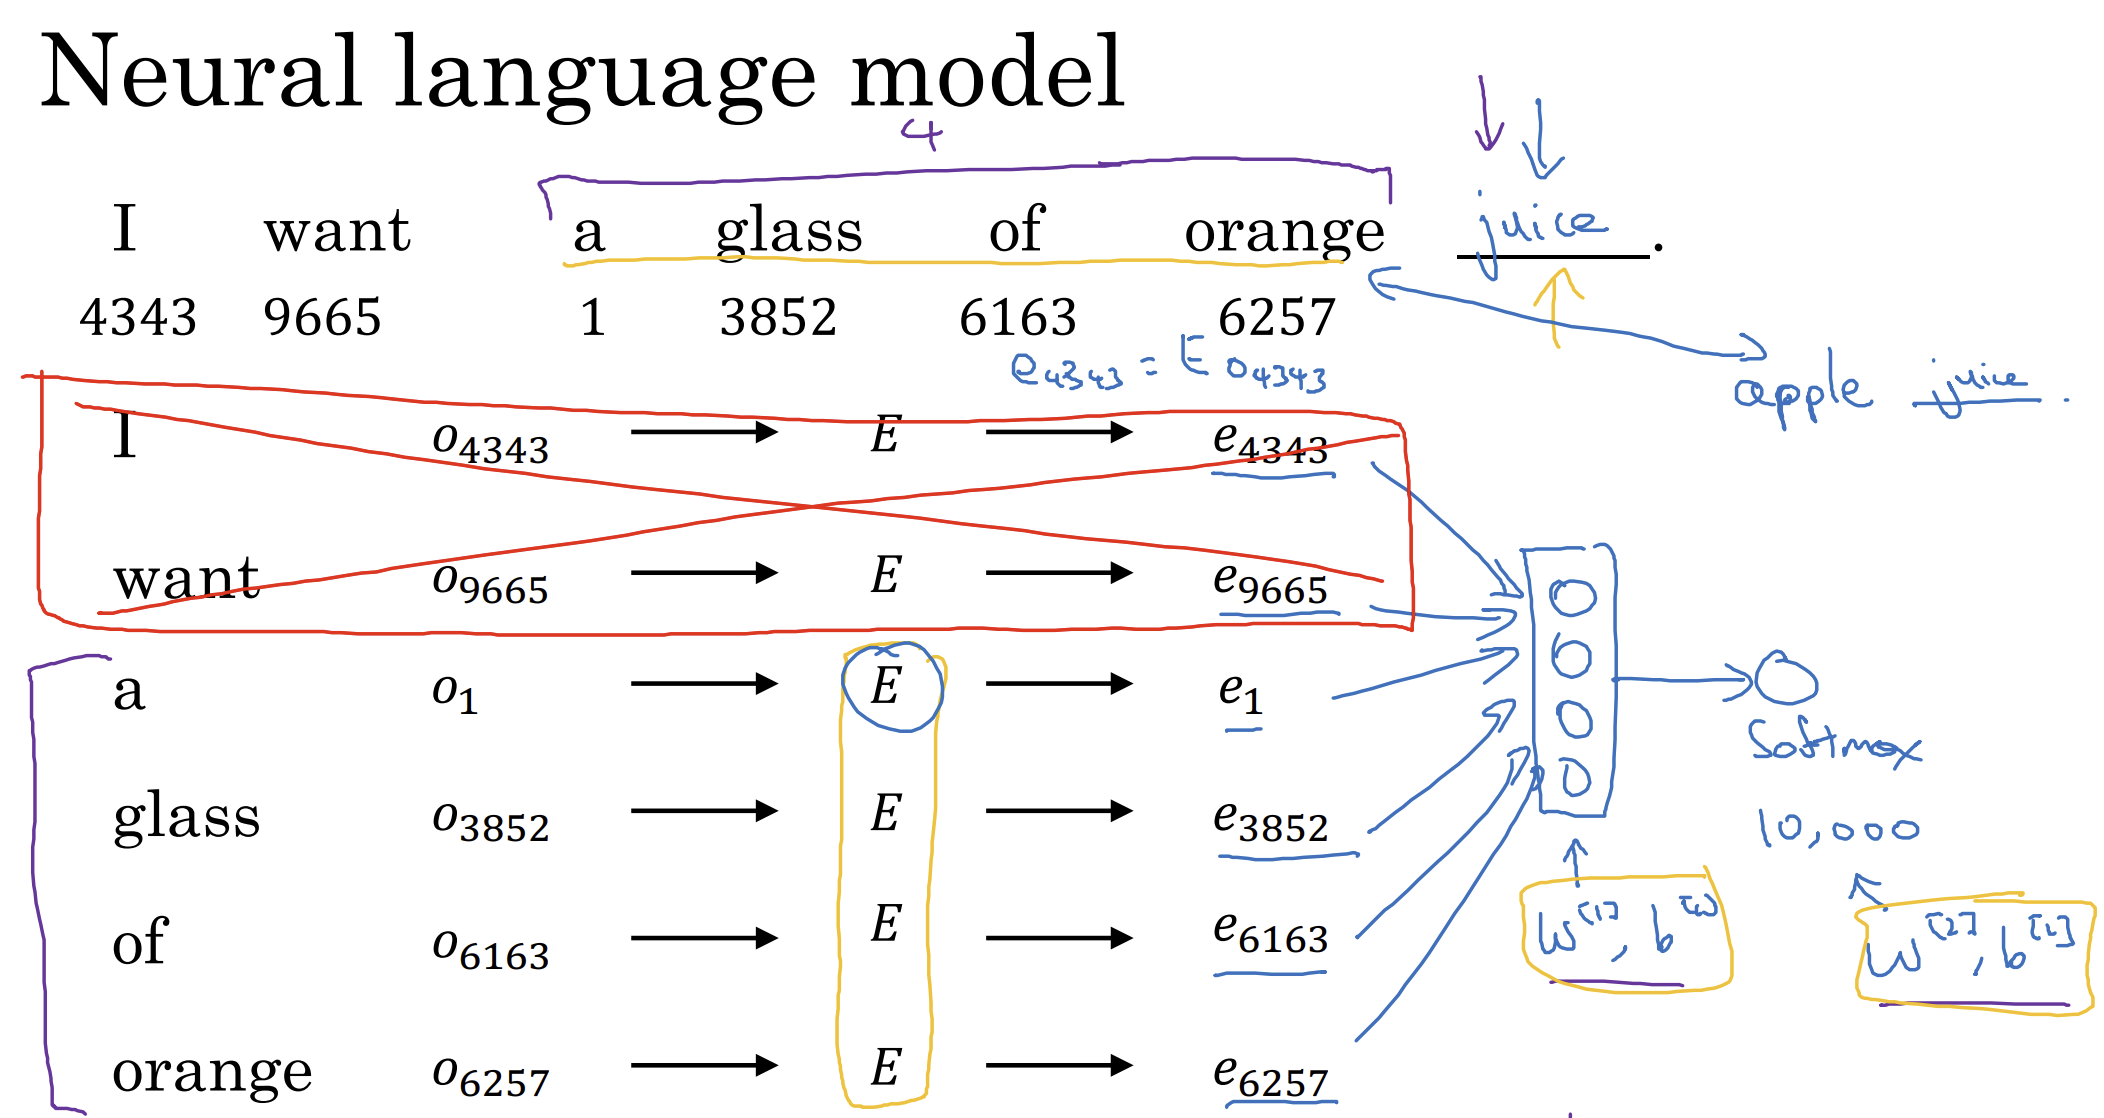

> note: In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix. We'll see this in <<chapter_anatomy>> when we use the `nn.Embedding` class.

We have two options to train such a model on our Twitter dataset:

- **_Feature extraction_**: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- **_Fine-tuning_**: We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In the following sections we explore both options for DistilBERT and examine their trade-offs.

### **Transformers as Feature Extractors**

We freeze the body's weights during training and use the hidden states as features for the classifier. <br>
The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="images/chapter02_encoder-feature-based.png" id="encoder-features"/>

#### Using pretrained models

We will use another convenient auto class from 🤗Transformers called `AutoModel`. Similar to the `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [34]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Converting token encodings into embeddings and extracts hidden states
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch `nn.Module.to()` method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

#### Extracting the last hidden states

To warm up, let's retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors. This can be done by providing the `return_tensors="pt"` argument to the tokenizer as follows:

In [35]:
text = "this is a test"

inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs

Input tensor shape: torch.Size([1, 6])


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [36]:
encoded_text = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']


As we can see, the resulting tensor has the shape `[batch_size, n_tokens]`. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:

In [37]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    # hidden state is returned
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Here we've used the `torch.no_grad()` context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a `namedtuple` in Python. In our example, the model output is an instance of `BaseModelOutput`, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:

In [38]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape `[batch_size, n_tokens, hidden_dim]`. In other words, a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the `[CLS]` token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into `outputs.last_hidden_state` as follows:

In [39]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now that we know how to get the last hidden state for a single string, let's do the same thing for the whole dataset by creating a new `hidden_state` column that stores all these vectors. As we did with the tokenizer, we'll use the `map()` method of `DatasetDict` to extract all the hidden states in one go. The first thing we need to do is wrap the previous steps in a processing function:

In [40]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

The only difference between this function and our previous logic is the final step where we place the final hidden state back on the CPU as a NumPy array. The `map()` method requires the processing function to return Python or NumPy objects when we're using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the `input_ids` and `attention_mask` columns to the `"torch"` format, as follows:

In [41]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [42]:
#Extracting hidden states
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Note that we did not set `batch_size=None` in this case, so the default `batch_size=1000` is used instead. As expected, applying the +extract_&#x200b;hid&#x2060;den_&#x200b;states()+ function has added a new `hidden_state` column to our dataset:

In [43]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [44]:
emotions_hidden["train"]['input_ids']

tensor([[  101,  1045,  2134,  ...,     0,     0,     0],
        [  101,  1045,  2064,  ...,     0,     0,     0],
        [  101, 10047,  9775,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2113,  ...,     0,     0,     0]])

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix - let's take a look.

#### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-Learn format as follows:

In [45]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Before we train a model on the hidden states, it's good practice to perform a sanity check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we'll see how visualizing the features provides a fast way to achieve this.

#### Visualizing the training set

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we'll use the powerful UMAPfootnote:[L. McInnes, J. Healy, and J. Melville, ["UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction"](https://arxiv.org/abs/1802.03426), (2018).] algorithm to project the vectors down to 2D.  Since UMAP works best when the features are scaled to lie in the [0,1] interval, we'll first apply a `MinMaxScaler` and then use the UMAP implementation from the `umap-learn` library to reduce the hidden states:

In [46]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=dac30ef7c3fb7627d7716d97fd83586d1062443e742a2240cc19038131397cd9
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [47]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.966281,6.852293,0
1,-3.244645,5.900747,0
2,5.220088,3.333539,3
3,-2.504164,4.025427,2
4,-3.420165,3.965217,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

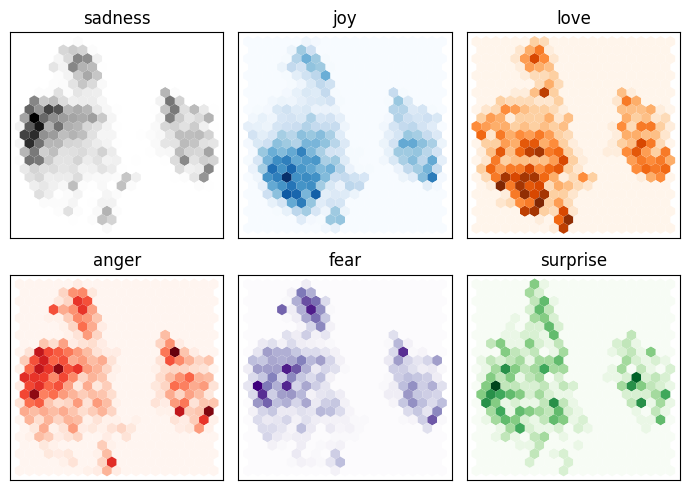

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotionData["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


>note: These are only projections onto a lower-dimensional space. Just because some categories overlap does not mean that they are not separable in the original space. Conversely, if they are separable in the projected space they will be separable in the original space.

From this plot we can see some clear patterns: the negative feelings such as `sadness`, `anger`, and `fear` all occupy similar regions with slightly varying distributions. On the other hand, `joy` and `love` are well separated from the negative emotions and also share a similar space. Finally, `surprise` is scattered all over the place. Although we may have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them implicitly by guessing the masked words in texts.

Now that we've gained some insight into the features of our dataset, let's finally train a model on it!

#### Training a simple classifier

We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn. Training such a simple model is fast and does not require a GPU:

In [49]:
# We increase `max_iter` to guarantee convergence
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [50]:
lr_clf.score(X_valid, y_valid)

0.634

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a `DummyClassifier` that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [51]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

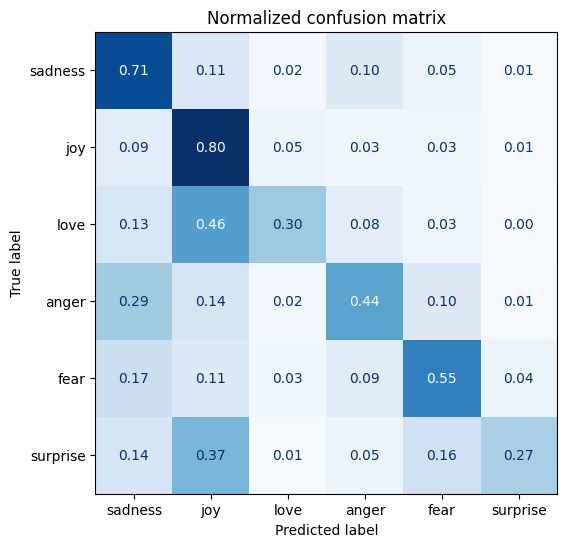

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that `anger` and `fear` are most often confused with `sadness`, which agrees with the observation we made when visualizing the embeddings. Also, `love` and `surprise` are frequently mistaken for `joy`.

### Fine-Tuning Transformers


Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in <<encoder-tuning>>. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="images/chapter02_encoder-fine-tuning.png" id="encoder-tuning"/>

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the `Trainer` API from 🤗 Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [53]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

#### Defining the performance metrics

To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [54]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

#### Training the model

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [55]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:

```bash
$ huggingface-cli login
```

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [56]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`:

In [57]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.848300,0.312485,0.902000,0.901599
2,0.242900,0.218119,0.926000,0.926096


Looking at the logs, we can see that our model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:

In [58]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [59]:
preds_output.metrics

{'test_loss': 0.21811892092227936,
 'test_accuracy': 0.926,
 'test_f1': 0.926095800480484,
 'test_runtime': 4.1897,
 'test_samples_per_second': 477.361,
 'test_steps_per_second': 7.638}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [60]:
y_preds = np.argmax(preds_output.predictions, axis=1)

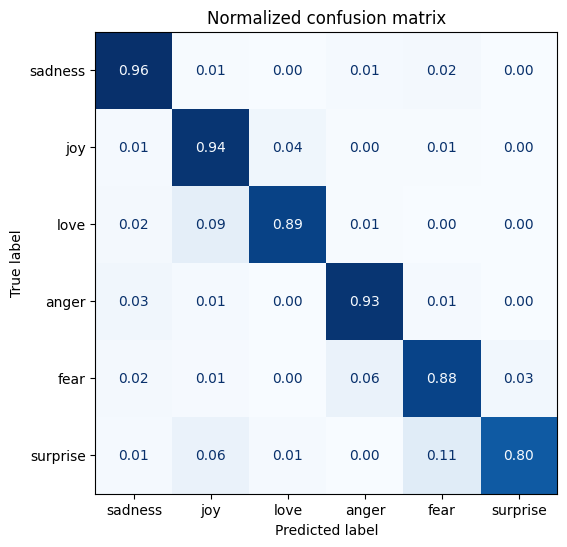

In [61]:
# plotting confusion matrix
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

#### Error analysis

Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:

In [62]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

Using the `map()` method once more, we can apply this function to get the losses for all the samples:

In [63]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Finally, we create a `DataFrame` with the texts, losses, and predicted/true labels:

In [64]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

We can clearly see that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether. In particular, `joy` seems to be mislabeled several times. With this information we can refine the dataset, which often can lead to as big a performance gain (or more) as having more data or larger models!

When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the `sadness` class. Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investing time into looking at the examples that the model is most confident about, so that we can be confident that the model does not improperly exploit certain features of the text. So, let's also look at the predictions with the smallest loss:

In [65]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.019968
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.020466
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.020513
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.020707
1310,i feel like an ungrateful asshole,sadness,sadness,0.020716
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.020738
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.020782
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.020805
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.020847
1780,ive explained that he is very creative and lov...,joy,joy,0.020890


We now know that the `joy` is sometimes mislabeled and that the model is most confident about predicting the label `sadness`. With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about.

The last step before serving the trained model is to save it for later usage. image:images/logo.png[hf,13,13] Transformers allows us to do this in a few steps, which we'll show you in the next section.

#### Saving and sharing the model

The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any community-generated model can be downloaded from the Hub just like we downloaded the DistilBERT model. With the `Trainer` API, saving and sharing a model is simple:

In [66]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1709826668.3730ee269726.1709.0:   0%|          | 0.00/6.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dragoa/distilbert-base-uncased-finetuned-emotion/commit/1ab87a6be2d5f68638661b51f0db2ae9529f9a7b', commit_message='Training completed!', commit_description='', oid='1ab87a6be2d5f68638661b51f0db2ae9529f9a7b', pr_url=None, pr_revision=None, pr_num=None)

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline:

In [67]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Then let's test the pipeline with a sample tweet:

In [68]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Finally, we can plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is `joy`, which appears to be reasonable given the tweet:

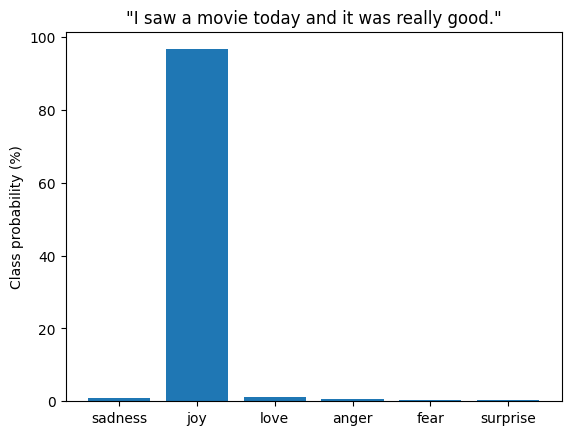

In [69]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()